# MIE1624 Introduction to Data Science and Analytics

## Final Exam Project COVID-19 Open Research

## Zichuan Wang - 1000474300

## 0. Learning objectives:

1. Implement functionality to parse natural language biomedical literature data according to given constraints and requirements.
2. Train and test machine learning algorithms (especially unsupervised machine learning algorithms such as clustering, dimensionality reduction, recommender systems, association rules, etc.) in order to gain insights or answer the overarching question you have chosen to pursue for this project.
3. Understand how to apply machine learning algorithms to the task of learning from a large corpus of biomedical research text.
4. Improve on skills and competencies required to collate and present domain specific, evidence-based insights. Particularly, in this case to gain insights and guide the fight against the COVID-19 pandemic.

### 0.1 Import libraries

In [1]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zichuanwang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/zichuanwang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/zichuanwang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from scipy.stats import norm
import time
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")
from sklearn.decomposition import PCA

from html.parser import HTMLParser
from bs4 import BeautifulSoup
import unicodedata
import re
import unicodedata
import html
from collections import Counter
from functools import reduce
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
import matplotlib.pyplot as plt
#from autocorrect import spell
from wordcloud import WordCloud
%matplotlib inline

import random
random.seed()

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import scipy.cluster.hierarchy as sch

# Set pandas view options
pd.set_option('max_rows',20)
pd.set_option('max_columns',800)

## 1 Data Cleaning – [5 Marks]:
The dataset of research papers is provided to you as a .csv file and starter Python code is provided to you that cleans the data by removing duplicate papers, making the text contents easier to mine by adjusting formatting, and extracting useful fields from the larger dataset such as authors, abstracts, date of publication and more. You may choose to use this starter code and clean data that it produces, or if your chosen algorithm requires a different format of data or approach, you are free to modify and/or write you own data cleaning pipeline.

### 1.1 Load the dataset and drop unnecessary columns

We are only interested in **title** and **abstract** fields

In [3]:
df=pd.read_csv('metadata.csv')
useful_cols = ['title','abstract']
df = df[useful_cols]
df = df.drop_duplicates(subset='abstract', keep="first")
df=df.dropna()
#change text to lowercase
df["abstract"] = df["abstract"].str.lower()
df["title"] = df["title"].str.lower()

### 1.2 Text Cleaning

1.   All text converted to lovercase
2.   All special characters removed
3.   All stop words removed
4.   Lemmatization applied

In [4]:
stop_words_list = stopwords.words("english")
def text_cleanning(text):
    # All characters in the text are in lowercase.
    text = str(text)
    text = text.lower()
    #All html tags and attributes (i.e., /<[^>]+>/) are removed
    regex_pattern = re.compile('[^A-Za-z0-9\s-]')
    text = re.sub(regex_pattern, ' ', text)
    #Remove duplicate spaces and strp front and end spaces
    text = re.sub(' +',' ',text)
    text = text.strip()
    #make text to a list of words
    text_list = text.split(' ')
    # All stop words are removed. Be clear in what you consider as a stop word.
    text_drop_stop_words_list = [x for x in text_list if x not in stop_words_list]
    #Reconstruct the list to string by adding space in between
    text = " ".join(text_drop_stop_words_list)
    return text

In [5]:
#Perform text cleaning for title and abstract
df['cleaned_title'] = df['title'].apply(text_cleanning)
df['cleaned_abstract'] = df['abstract'].apply(text_cleanning)

In [6]:
#Apply Lemmatization
df['cleaned_title'] = df['cleaned_title'].apply(lambda x: WordNetLemmatizer().lemmatize(x,'v'))
df['cleaned_abstract'] = df['cleaned_abstract'].apply(lambda x: WordNetLemmatizer().lemmatize(x,'v'))
df = df.dropna()
df.head()

,title,abstract,cleaned_title,cleaned_abstract
0,siann: strain identification by alignment to n...,next-generation sequencing is increasingly bei...,siann strain identification alignment near nei...,next-generation sequencing increasingly used s...
1,spatial epidemiology of networked metapopulati...,an emerging disease is one infectious epidemic...,spatial epidemiology networked metapopulation ...,emerging disease one infectious epidemic cause...
2,sequencing of the human ig light chain loci fr...,germline variation at immunoglobulin gene (ig)...,sequencing human ig light chain loci hydatidif...,germline variation immunoglobulin gene ig loci...
3,bayesian mixture analysis for metagenomic comm...,deep sequencing of clinical samples is now an ...,bayesian mixture analysis metagenomic communit...,deep sequencing clinical samples established t...
4,mapping a viral phylogeny onto outbreak trees ...,developing methods to reconstruct transmission...,mapping viral phylogeny onto outbreak trees im...,developing methods reconstruct transmission hi...


In [7]:
print("The size of dataset after cleaning is:\n",df.shape)

The size of dataset after cleaning is:
 (37531, 4)


## 2 Data Visualization and Exploratory Data Analysis – [15 Marks]:
Depending on your overarching theme and questions that you wish to address about COVID-19 present 3 graphical figures that visualize aspects or information in the data that you will further explore with your models. How could these trends be used to help with the task of methodically extracting all information and trends of this type? Consider how accessing the data and creating these visualizations will inform how the data will need to be pre-processed and fed into your models. All graphs should be readable and presented in the notebook. All axes must be appropriately labeled. In addition to data visualizations, perform exploratory data analysis in other forms, if necessary.

### Visualization Graph\#1 Appearance frequency of different types of coronavirus

Here we are considering three main coronavirus outbreaks, namely, **SARS** during 2003, **MERS** during 2012 and **COVID-19** during 2019. 

In [8]:
#Define the keywords related to those three coronavirus outbreaks
virus_key_map = dict()
virus_key_map['mers-cov'] = ['mers-cov','middle','east','middle-east','mers']
virus_key_map['sars-cov'] = ['sars-cov','sars']
virus_key_map['covid-19'] = ['covid-19','sars-cov-2','2019-ncov']

In [9]:
#The function used to determine type of coronavirus
def which_virus(text):
    counter = dict()
    counter['mers-cov'] = 0
    counter['sars-cov'] = 0
    counter['covid-19'] = 0
    text_list = text.split(' ')
    for word in text_list:
        for key in virus_key_map:
            if word in virus_key_map[key]:
                counter[key] +=1
                continue
    all_vals = counter.values()
    if max(all_vals) == 0:
        return 'None/Others'
    else:
        return max(counter, key=counter.get)

In [10]:
#Add a colummn to for type of coronavirus
df['virus_type'] = df['cleaned_abstract'].apply(lambda x: which_virus(x))
df.head()

,title,abstract,cleaned_title,cleaned_abstract,virus_type
0,siann: strain identification by alignment to n...,next-generation sequencing is increasingly bei...,siann strain identification alignment near nei...,next-generation sequencing increasingly used s...,None/Others
1,spatial epidemiology of networked metapopulati...,an emerging disease is one infectious epidemic...,spatial epidemiology networked metapopulation ...,emerging disease one infectious epidemic cause...,sars-cov
2,sequencing of the human ig light chain loci fr...,germline variation at immunoglobulin gene (ig)...,sequencing human ig light chain loci hydatidif...,germline variation immunoglobulin gene ig loci...,None/Others
3,bayesian mixture analysis for metagenomic comm...,deep sequencing of clinical samples is now an ...,bayesian mixture analysis metagenomic communit...,deep sequencing clinical samples established t...,None/Others
4,mapping a viral phylogeny onto outbreak trees ...,developing methods to reconstruct transmission...,mapping viral phylogeny onto outbreak trees im...,developing methods reconstruct transmission hi...,None/Others


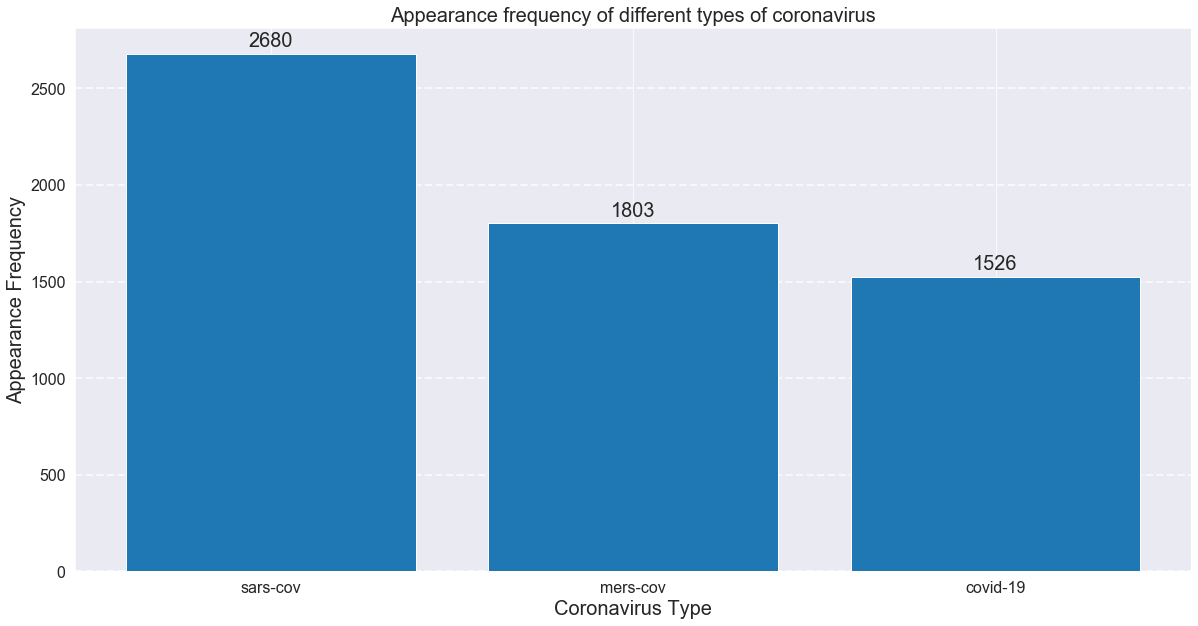

In [50]:
#Plot histogram of appearance frequency of different types of coronavirus
counter = df[df["virus_type"] != "None/Others"].groupby('virus_type')['virus_type'].count()
counter = counter.sort_values(ascending=False)
plt.figure(figsize=(20,10))
plt.bar(counter.keys(),counter)
plt.title('Appearance frequency of different types of coronavirus',fontdict={'size':20})
plt.xlabel('Coronavirus Type',fontsize=20)
plt.ylabel('Appearance Frequency',fontsize=20)
ax = plt.gca()
ind = 0
for key in counter.keys():
    ax.annotate(str(counter[key]),xy=(ind, counter[key]),xytext=(0, 3),textcoords="offset points",ha='center',
                va='bottom',fontsize=20)
    ind += 1
ax.grid(linestyle='--', linewidth=2, axis='y', alpha=0.7)
plt.tick_params(labelsize=16, pad=6)
plt.show()

**From the above figure, we can tell that:**

> Out of the three outbreaks, the most frequently mentioned one is SARS with 2680 related papers, followed by MERS with 1803 papers, and lastly COVID19 with 1526 papers.

> The ranking make sense since COVID19 is really similar to SARS, therefore for papers which include covid19 is likely to include SARS as well. COVID19 just happened last year, that's why it has the last number of related research papers.

**For the rest of the analysis, I will only focus on research papers related to the three main coronavirus outbreaks.**

In [12]:
df_selected = df[df["virus_type"] != "None/Others"]
virus_type_encoder = {
    'mers-cov':0,
    'sars-cov':1,
    'covid-19':2,
}
df_selected['virus_type_code'] = df_selected['virus_type'].apply(lambda x: virus_type_encoder[x])
print("Selected number of data entries:", df_selected.shape[0])

Selected number of data entries: 6009


### Visualization Graph\#2 Top 10 coronavirus related symptoms with highest appearance frequency

In [13]:
#Comprehensive list of coronavirus related symptoms
symptoms = ['pneumonia','clod','sore throat','weight loss','chills','shivering','dyspnea','convulsions',
            'deformity','dizziness','vertigo','fatigue','malaise','asthenia','hypothermia','jaundice',
            'muscle weakness','pyrexia','sweats','swelling','swollen','painful lymph node','weight gain',
            'arrhythmia','bradycardia','chest pain','claudication','palpitations','tachycardia','dry mouth',
            'epistaxis','halitosis','hearing loss','nasal discharge','otalgia','otorrhea','sore throat',
            'toothache','tinnitus','trismus','abdominal pain','fever','bloating','belching','bleeding',
            'blood in stool','melena','hematochezia', 'constipation','diarrhea','dysphagia','dyspepsia',
            'fecal incontinence','flatulence','heartburn','nausea','odynophagia','proctalgia fugax','pyrosis',
            'steatorrhea','vomiting','alopecia','hirsutism','hypertrichosis','abrasion','anasarca',
            'bleeding into the skin','petechia','purpura','ecchymosis and bruising','blister','edema',
            'itching','laceration','rash','urticaria','abnormal posturing','acalculia','agnosia','alexia',
            'amnesia','anomia','anosognosia','aphasia and apraxia','apraxia','ataxia','cataplexy','confusion',
            'dysarthria','dysdiadochokinesia','dysgraphia','hallucination','headache','akinesia','bradykinesia',
            'akathisia','athetosis','ballismus','blepharospasm','chorea','dystonia','fasciculation','muscle cramps',
            'myoclonus','opsoclonus','tremor','flapping tremor','insomnia','loss of consciousness','syncope',
            'neck stiffness','opisthotonus','paralysis and paresis','paresthesia','prosopagnosia','somnolence',
            'abnormal vaginal bleeding','vaginal bleeding in early pregnancy', 'miscarriage',
            'vaginal bleeding in late pregnancy','amenorrhea','infertility','painful intercourse','pelvic pain',
            'vaginal discharge','amaurosis fugax','amaurosis','blurred vision','double vision','exophthalmos',
            'mydriasis','miosis','nystagmus','amusia','anhedonia','anxiety','apathy','confabulation','depression',
            'delusion','euphoria','homicidal ideation','irritability','mania','paranoid ideation',
            'suicidal ideation','apnea','hypopnea','cough','dyspnea','bradypnea','tachypnea','orthopnea',
            'platypnea','trepopnea','hemoptysis','pleuritic chest pain','sputum production','arthralgia',
            'back pain','sciatica','Urologic','dysuria','hematospermia','hematuria','impotence','polyuria',
            'retrograde ejaculation','strangury','urethral discharge','urinary frequency','urinary incontinence',
            'urinary retention']
symptoms_counter = dict()
for key in symptoms:
    if key not in symptoms_counter:
        symptoms_counter[key] = 0

#loop through the dataset and count what kind of symptom is mentioned most
for symptom in symptoms_counter:
    for cleaned_abstract in df['cleaned_abstract']:
        if symptom in cleaned_abstract:
            symptoms_counter[symptom] += 1

In [14]:
#sort the dictionary from highest value to lowest
symptoms_counter = sorted(symptoms_counter.items(), key=lambda x: x[1],reverse=True) 
#Only keep the first 10 symptoms 
symptoms_counter = dict(symptoms_counter[:10])
#resort the dictionary since the above step break the order
symptoms_counter = sorted(symptoms_counter.items(), key=lambda x: x[1],reverse=True) 
symptoms_counter = dict(symptoms_counter)

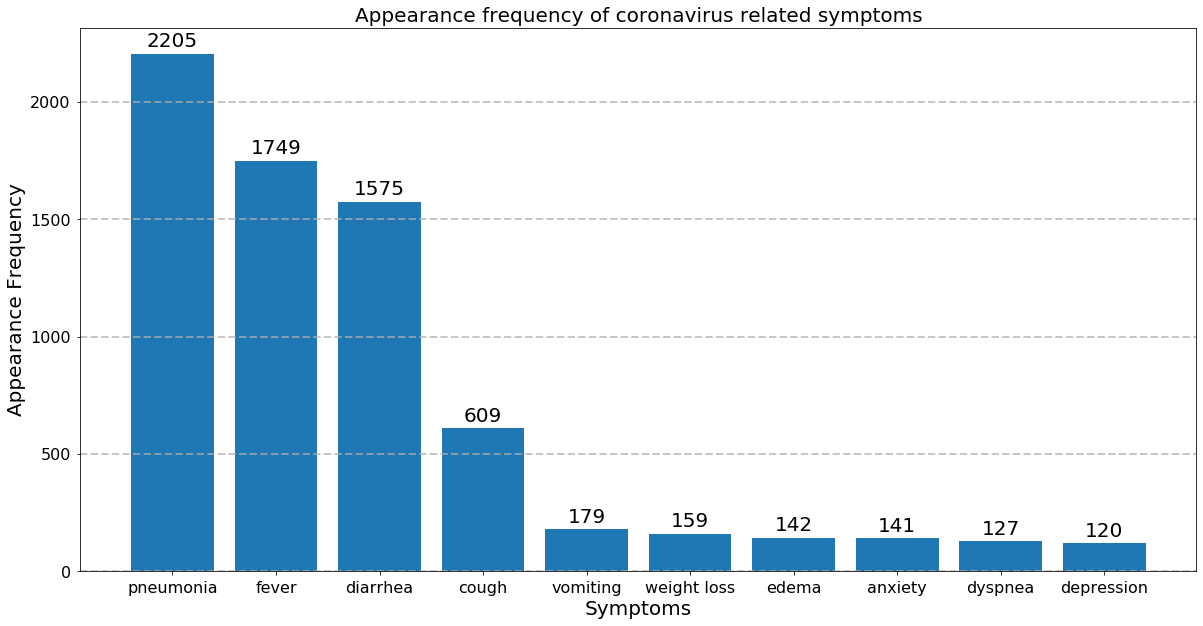

In [15]:
#plot histogram of top 10 coronavirus related symptoms with highest appearance frequency
plt.figure(figsize=(20,10))
plt.bar(range(len(symptoms_counter)), list(symptoms_counter.values()), align='center')
plt.xticks(range(len(symptoms_counter)), list(symptoms_counter.keys()))
plt.title('Appearance frequency of coronavirus related symptoms',fontdict={'size':20})
plt.xlabel('Symptoms',fontsize=20)
plt.ylabel('Appearance Frequency',fontsize=20)
ax = plt.gca()
ind = 0
for key in symptoms_counter.keys():
    ax.annotate(str(symptoms_counter[key]),xy=(ind, symptoms_counter[key]),xytext=(0, 3),textcoords="offset points",
                ha='center', va='bottom',fontsize=20)
    ind +=1
ax.grid(linestyle='--', linewidth=2, axis='y', alpha=0.7)
plt.tick_params(labelsize=16, pad=6)
plt.show()

**From the above figure, we can tell that:**


> The most commonly mentioned symptom is "pneumonia" with 2205 related papers, followed by "fever" with 1749 related papers and "diarrhea" with 1575 related papers. Cough is mentioned in 609 related papers. All the rest of symptoms are mentioned under 200 related papers.

In [16]:
df_selected['cleaned_abstract_split'] = df_selected['cleaned_abstract'].str.split()
df_selected.head()

,title,abstract,cleaned_title,cleaned_abstract,virus_type,virus_type_code,cleaned_abstract_split
1,spatial epidemiology of networked metapopulati...,an emerging disease is one infectious epidemic...,spatial epidemiology networked metapopulation ...,emerging disease one infectious epidemic cause...,sars-cov,1,"[emerging, disease, one, infectious, epidemic,..."
8,mers-cov recombination: implications about the...,recombination is a process that unlinks neighb...,mers-cov recombination implications reservoir ...,recombination process unlinks neighbouring loc...,mers-cov,0,"[recombination, process, unlinks, neighbouring..."
28,containing emerging epidemics: a quantitative ...,abstractstrategies for containing an emerging ...,containing emerging epidemics quantitative com...,abstractstrategies containing emerging infecti...,sars-cov,1,"[abstractstrategies, containing, emerging, inf..."
46,prophage genomics reveals patterns in phage ge...,abstracttemperate phage genomes are highly var...,prophage genomics reveals patterns phage genom...,abstracttemperate phage genomes highly variabl...,mers-cov,0,"[abstracttemperate, phage, genomes, highly, va..."
54,quantifying the risk and cost of active monito...,abstractduring outbreaks of deadly emerging pa...,quantifying risk cost active monitoring infect...,abstractduring outbreaks deadly emerging patho...,mers-cov,0,"[abstractduring, outbreaks, deadly, emerging, ..."


### Visualization Graph\#3 WordCloud for different types of coronavirus

#### MERS-CoV WordCloud

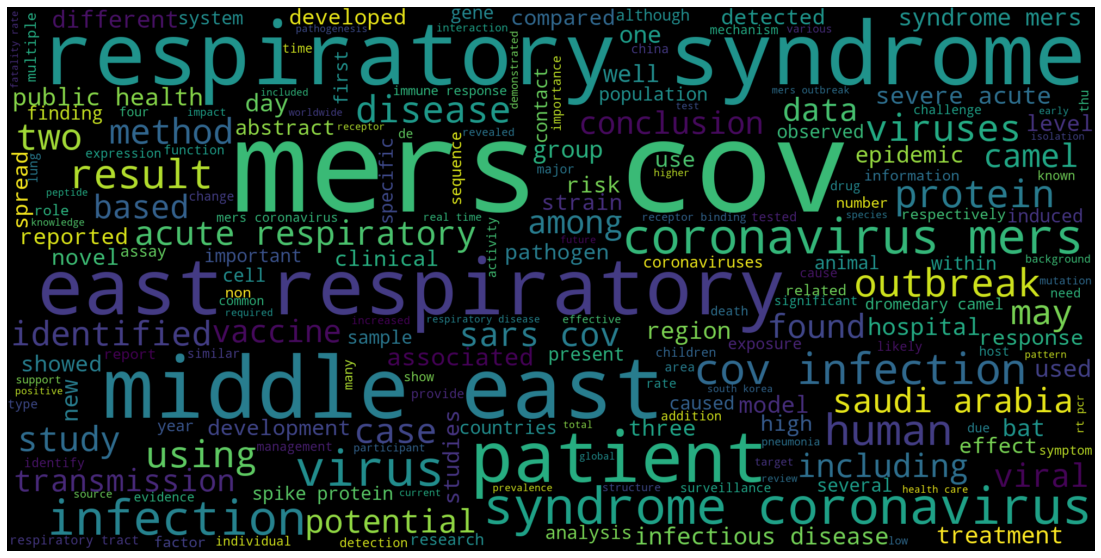

In [17]:
df_mers=df_selected[df_selected['virus_type']=='mers-cov']['cleaned_abstract_split'].apply(lambda x:" ".join(x))
df_mers_wordcloud=" ".join(df_mers)
# Create and generate a word cloud image:
wordcloud = WordCloud(width = 2000, height = 1000,max_words=200,background_color="black").generate(df_mers_wordcloud)
# Display the generated image:
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

>#### From the word cloud of MERS, we can see that related research papers have key words such as "respiratory syndrome" meaning MERS comes with various respiratory syndrome, and "Middle East" meaning this virus originate from middle east.

#### SARS-CoV WordCloud

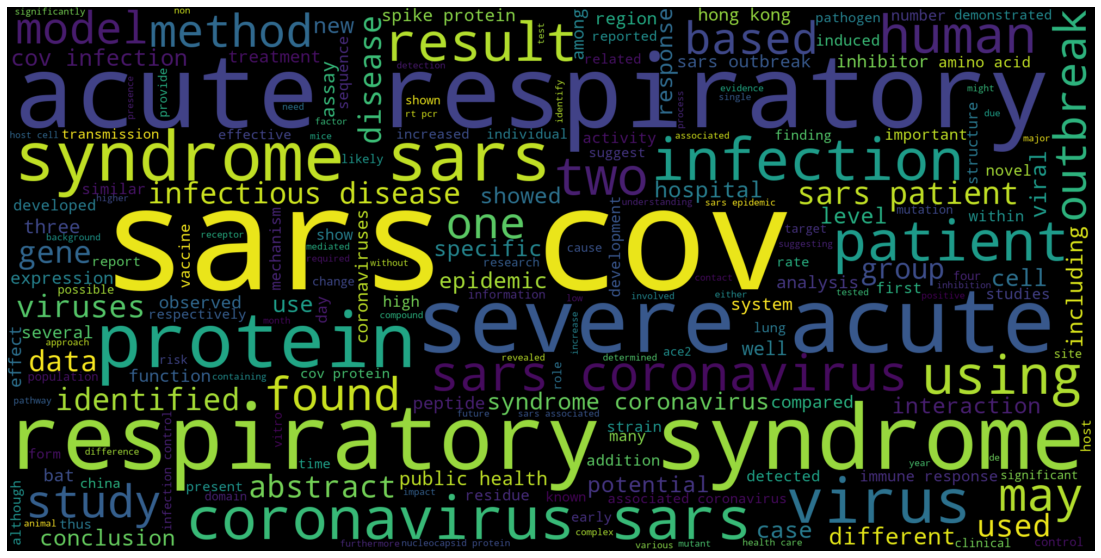

In [18]:
df_mers=df_selected[df_selected['virus_type']=='sars-cov']['cleaned_abstract_split'].apply(lambda x:" ".join(x))
df_mers_wordcloud=" ".join(df_mers)
# Create and generate a word cloud image:
wordcloud = WordCloud(width = 2000, height = 1000,max_words=200,background_color="black").generate(df_mers_wordcloud)
# Display the generated image:
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

>#### From the word cloud of SARS, we can see that related research papers have key words such as "acute respiratory" and "severe acute" meaning SARS is an acute illness, and "infection" meaning SARS is highly contagious.

#### COVID-19 WordCloud

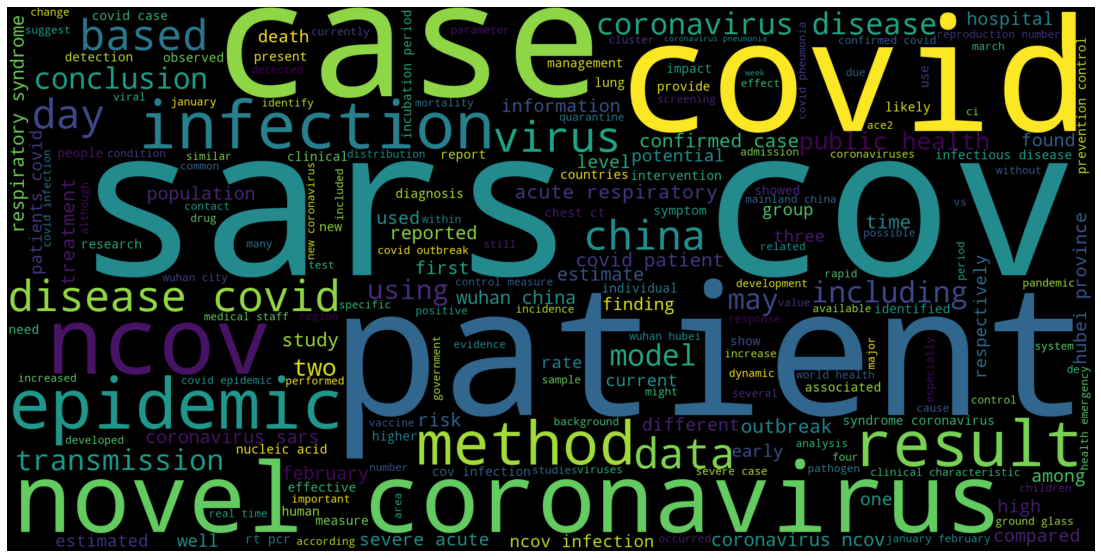

In [19]:
df_mers=df_selected[df_selected['virus_type']=='covid-19']['cleaned_abstract_split'].apply(lambda x:" ".join(x))
df_mers_wordcloud=" ".join(df_mers)
# Create and generate a word cloud image:
wordcloud = WordCloud(width = 2000, height = 1000,max_words=200,background_color="black").generate(df_mers_wordcloud)
# Display the generated image:
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

>#### From the word cloud of COVID19, we can see that related research papers have key words such as "SARS" meaning COVID19 is found to be closely related to SARS, and "novel" meaning COVID19 got discovered recently.

### Visualization Graph\#4 Word embeddings for COVID-19

In [43]:
from gensim.models import Word2Vec
from gensim.test.utils import common_texts
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20)
#min_count= int Ignores all words with total absolute frequency lower than this - (2, 100)
#window = int - The maximum distance between the current and predicted word within a sentence. E.g. window words on the left and window words on the left of our target - (2, 10)
#size = int - Dimensionality of the feature vectors. - (50, 300)
#sample = float - The threshold for configuring which higher-frequency words are randomly downsampled. Highly influencial. - (0, 1e-5)
#alpha = float - The initial learning rate - (0.01, 0.05)
#min_alpha = float - Learning rate will linearly drop to min_alpha as training progresses. To set it: alpha - (min_alpha * epochs) ~ 0.00
#negative = int - If > 0, negative sampling will be used, the int for negative specifies how many "noise words" should be drown. If set to 0, no negative sampling is used. - (5, 20)
#workers = int - Use these many worker threads to train the model (=faster training with multicore machines)

# Word2Vec requires tokenized lists as input, which we prepared when cleaning our text
sentences=df_selected[df_selected['virus_type']=='covid-19']['cleaned_abstract_split']

w2v_model.build_vocab(sentences, progress_per=10000)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)
w2v_model.init_sims(replace=True)# make the model much more memory-efficient:

In [44]:
a=[]
for keys in w2v_model.wv.vocab.keys():
    a.append(w2v_model.wv.get_vector(keys))
matrix = pd.DataFrame(a)
matrix = np.transpose(matrix)

matrix.columns=w2v_model.wv.vocab.keys()
matrix

reported     world    health  organization     novel  coronavirus  \
0   -0.086167 -0.007879  0.014833     -0.017621 -0.019060    -0.048639   
1    0.026228  0.061624  0.090879      0.084464 -0.010803     0.010220   
2   -0.045483 -0.049498 -0.015103     -0.035211 -0.009501     0.003546   
3   -0.111935 -0.105482 -0.045634     -0.086679 -0.097414    -0.059013   
4    0.058487  0.097326  0.101419      0.099076  0.131020     0.117388   
..        ...       ...       ...           ...       ...          ...   
295 -0.062123  0.031618  0.052666      0.032525  0.008125     0.014993   
296 -0.015123 -0.021504 -0.031563     -0.030528  0.023455     0.021660   
297  0.011410  0.009948  0.016321      0.033029  0.011823     0.042599   
298  0.039465  0.027947  0.016544      0.019584  0.047935     0.020704   
299 -0.008442  0.017743  0.018207      0.014526 -0.001842    -0.033457   

     2019-ncov  identified  causative     virus     wuhan  pneumonia  \
0    -0.056945   -0.079285  -0.028016 -0.037591 -0.064319  -0.037065   
1    -0.035835   -0.040621  -0.020008 -0.068789  0.084341   0.059144   
2    -0.031033   -0.038015  -0.027966 -0.042593 -0.018826   0.043709   
3    -0.080145   -0.101520  -0.069303 -0.038282 -0.097118  -0.037470   
4     0.093867    0.038266   0.104031  0.060450  0.056508   0.131500   
..         ...         ...        ...       ...       ...        ...   
295  -0.012047   -0.033142   0.021174  0.029186 -0.078634  -0.038399   
296  -0.019330   -0.019149   0.005955  0.000070 -0.064814   0.013028   
297   0.053362    0.039692   0.023181  0.027432 -0.043572   0.024320   
298   0.028024    0.021788   0.016528 -0.020784  0.025360   0.049426   
299   0.025743    0.005324   0.002741 -0.000447  0.045465  -0.017982   

      unknown   chinese  authorities         7   january      2020     study  \
0   -0.033706 -0.004789     0.010031 -0.129571 -0.083934 -0.081848 -0.043501   
1   -0.017008  0.111145     0.059862  0.094223  0.100391  0.087315 -0.028206   
2   -0.008422  0.009649    -0.032804  0.007709 -0.037442 -0.043008  0.072676   
3   -0.046305 -0.021117    -0.067024  0.035252 -0.106721 -0.109538 -0.076732   
4    0.065665  0.089418     0.087092 -0.029618  0.043952  0.045588  0.106290   
..        ...       ...          ...       ...       ...       ...       ...   
295 -0.001766  0.013529     0.026866 -0.095096 -0.080251 -0.073042 -0.029547   
296 -0.008817 -0.061254    -0.040773 -0.044979 -0.067768 -0.061994 -0.009898   
297  0.000315 -0.013002    -0.022565  0.040512  0.029022  0.029850  0.011825   
298  0.026208  0.036386     0.044869  0.013852  0.068740  0.064320  0.058308   
299  0.022522  0.056381     0.051615 -0.008032  0.058344  0.056621  0.028690   

     developed  transmission   network     model  potential  infection  \
0    -0.047627      0.014177 -0.014777 -0.023600   0.015187  -0.034087   
1    -0.021077     -0.048482 -0.104173 -0.099677  -0.129326   0.011226   
2     0.023832     -0.042537 -0.000728 -0.028660   0.024372   0.020176   
3    -0.050759     -0.025391 -0.080909 -0.145991  -0.001608   0.018758   
4     0.073394      0.043806 -0.008007 -0.036970   0.041444   0.120837   
..         ...           ...       ...       ...        ...        ...   
295   0.019676     -0.018176  0.033893 -0.010746   0.054299  -0.023797   
296  -0.017487     -0.000496 -0.023377 -0.006533   0.031493  -0.005138   
297   0.076645     -0.066587  0.003718 -0.053125  -0.030541   0.013443   
298   0.018371      0.038166  0.026848  0.056209  -0.001648   0.039243   
299  -0.010399      0.052585  0.049204  0.043117  -0.003277   0.001050   

       source      bats     human     since   explore    public  concerns  \
0    0.007213 -0.045646 -0.014486 -0.039709  0.006865  0.036824  0.015250   
1   -0.017393 -0.042780 -0.109014  0.049997 -0.066666  0.046219  0.047135   
2   -0.025217 -0.001777  0.004067 -0.052168  0.087598 -0.005407 -0.014560   
3   -0.035204 -0.009441 -0.014284 -0.095233 -0.053160 -0.055197 -0.052123   
4    0.072472  0

In [45]:
### Plotting our Word2Vec results for visualizing our vocabulary in 2D space

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerPatch
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=20).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    
    plt.title('t-SNE visualization for {}'.format(word.title()), fontsize=20)
    
    red_patch = mpatches.Patch(color='red', label='Target word')
    green_patch = mpatches.Patch(color='green', label='Similar words')
    red_dot, = plt.plot(500, "ro", markersize=5)
    green_dot, = plt.plot(500, "go", markersize=5)
    plt.legend([red_dot, (red_dot, green_dot)], ["Target word", "Similar words"])

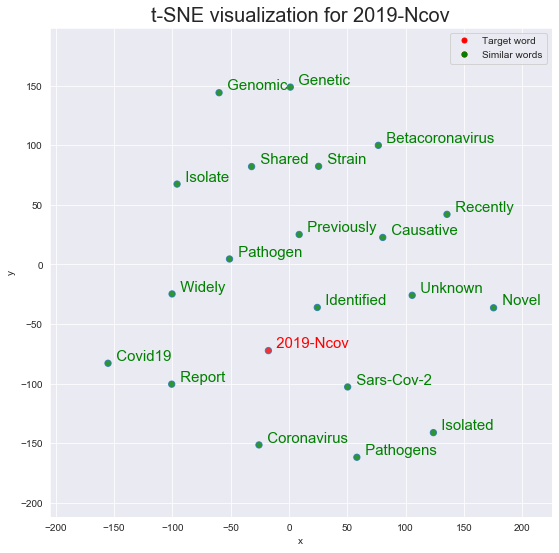

In [49]:
target = '2019-ncov'
tsnescatterplot(w2v_model, target, [t[0] for t in w2v_model.wv.most_similar(positive=[target], topn=20)][10:])

## 3.Model selection and fitting to data – [50 Marks]:
Select a machine learning model of your choice (you may select an unsupervised or
supervised machine learning model depending on your approach) that will allow you to
study some aspect of COVID-19 from the corpus of research articles. You must justify
your algorithm choices and the approach you will use to fit your model using the dataset
provided. You may also choose to study multiple models and report on the suitability of
each in addressing your overarching question regarding COVID-19. You should also use
the dataset provided to train the models selected and discuss and interpret the findings of
these models. You may also use this section to improve the model depending on the
findings of your models and how you interpret them.

### 3.1 Supervised machine learning for virus type identification

Use virus type label generated previously to conduct supervised machine learning for virus type classification.

#### 3.1.1 Text Feature Extraction
DataGenerator class is responsible for extracting text features using different method, namely word frequency (WF) and TF-IDF. **Train test split** feature is also integrated into the class.

In [20]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

class DataGenerator(object):
    def __init__(self,dataFrame):
        super().__init__()
        self.dataFrame = dataFrame

    def generate(self,feature_column,label_column,method="tf-idf",top=1000):
        if method=="tf-idf":
            return self._generate_tf_idf(feature_column,label_column)
        elif method=="wf":
            return self._generate_wf(feature_column,label_column)
        else:
            print("Please check your data generation method.")
            return None

    # TF-IDF
    def _generate_tf_idf(self,feature_column,label_column):
        # transform all text data into TF-IDF features
        count_vector = CountVectorizer(stop_words='english')
        X = count_vector.fit_transform(self.dataFrame[feature_column].apply(lambda x:" ".join(x)))
        Y = self.dataFrame[label_column]
        return X,Y,count_vector
    
    # WF
    def _generate_wf(self,feature_column,label_column):
        # transform all text data into WF features
        tfidf_vector = TfidfVectorizer(stop_words='english')
        X = tfidf_vector.fit_transform(self.dataFrame[feature_column].apply(lambda x:" ".join(x)))
        Y = self.dataFrame[label_column]
        return X,Y,tfidf_vector

    def split_data(self,X,Y,percent=[0.7,0.3],random_state=42):
        # train test split of 70% and 30%
        if len(percent) == 2:
            X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=percent[1], random_state=random_state)
            return X_train,X_test,y_train,y_test
        elif len(percent) == 3:
            print("You also create validation set...")
            X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=percent[1], random_state=random_state)
            X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=percent[2]/(1-percent[1]), random_state=random_state)
            return X_train,X_valid,X_test,y_train,y_valid,y_test
        else:
            print("Please check you percent.\n")
            return None

#### 3.1.2 Model implemetation

Multiple classification algorithms **(logistic regression, Naive Bayes, SVM)** are implemented and compared. TF-IDF is used for text feature extraction. **5-fold cross validation** and **70% 30% test train split** are universally applied to all algorithems.

In [21]:
from collections import OrderedDict

from sklearn.linear_model import LogisticRegression as lr
from sklearn.naive_bayes import BernoulliNB as bnb
from sklearn.naive_bayes import MultinomialNB as mnb
from sklearn.svm import LinearSVC as lsvc
from sklearn.ensemble import RandomForestClassifier as rf
from sklearn.calibration import CalibratedClassifierCV

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve, auc

class Classifier(object):
    def __init__(self,train_data,train_labels):
        super().__init__()
        self.train_data = train_data
        self.train_labels = train_labels
        self.models=OrderedDict([('LogisticRegression',[lr(C=1.0),dict(C=np.arange(0.1,3,0.2))]),\
                                 ('MultinomialNB',[mnb(alpha=5.0),dict(alpha=np.arange(0.1,10,1))]),\
                                 ('BernoulliNB',[bnb(alpha=5.0),dict(alpha=np.arange(0.1,10,1))]),\
                                 ('LinearSVC',[lsvc(C=0.1),dict(C=np.arange(0.1,3,0.2))]),\
                                 ('RandomForestClassifier',[rf(n_estimators=40,random_state=0),dict(n_estimators=np.arange(10,50,10))])
                                ])
        #1.1 and 2.70
    def train_model(self,model_name,ifhyper_tune=False,hyper_paras=""):
        model = self.models[model_name][0]
        if model_name == 'LinearSVC' and ifhyper_tune==False:
            model = CalibratedClassifierCV(model)
        if ifhyper_tune:
            if not hyper_paras:
                hyper_paras = self.models[model_name][1]
            # Grid search method for hyper-parameter tuning in which we use 5-fold cross validation
            if hyper_paras:
                grid = GridSearchCV(model, hyper_paras, cv=5, scoring='accuracy', n_jobs=-1) 

                grid.fit(self.train_data, self.train_labels)
                print('The best score of model {} through 5-cross validation is {}, with the best hyper-parameter {}\n'\
                    .format(model_name, grid.best_score_, grid.best_params_))

                # Best model
                best_model = grid.best_estimator_
            else:
                best_model = model.fit(self.train_data,self.train_labels)
        else:
            best_model = model.fit(self.train_data,self.train_labels)
        train_pred = best_model.predict(self.train_data)
        print('Train accuracy of {} model is {}\n'.format(model_name,accuracy_score(self.train_labels,train_pred)))
        return best_model, accuracy_score(self.train_labels,train_pred)

    def test_model(self,best_model,test_data,test_labels,if_report=False,model_name=""):
        test_pred = best_model.predict(test_data)
        
        cm = confusion_matrix(test_labels, test_pred)
        #test accuracy
        print('Model {} has test accuracy {}\n'.format(model_name, accuracy_score(test_labels,test_pred)))
        #test result report
        if if_report:
            print('Test result report:\n\n', classification_report(test_labels, test_pred),'\n')
            if len(set(test_labels))==2 and model_name!='LinearSVC':
                test_score = best_model.predict_proba(test_data)
                print('ROC plot and corresponding AUC:\n')
                self.plot_roc(test_labels,test_score)
            elif len(set(test_labels))>2:
                self.plot_confusion_matrix(cm)
        return accuracy_score(test_labels,test_pred),cm

    def plot_roc(self,true, score):
        preds = score[:,1]
        fpr, tpr, threshold = roc_curve(true, preds)
        roc_auc = auc(fpr, tpr)
        plt.title('Receiver Operating Characteristic')
        plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')

    def plot_confusion_matrix(self,cm):
        # plot the confusion matrix
        plt.figure(figsize=(10,10))
        plt.matshow(cm, fignum=1)
        ax = plt.gca()
        virus_type = ['MERS', 'SARS', 'COVID19']
        ax.set_xticklabels(['']+virus_type)
        ax.set_yticklabels(['']+virus_type)
        plt.show()

In [22]:
virusTypeGenerator = DataGenerator(df_selected)
df_X, df_Y,df_feature = virusTypeGenerator.generate("cleaned_abstract_split","virus_type_code","tf-idf")
df_X_train,df_X_test,df_y_train,df_y_test = virusTypeGenerator.split_data(df_X,df_Y,percent=[0.7,0.3])

In [23]:
virusTypeClassifier = Classifier(df_X_train,df_y_train)

#### Logistic Regression

Regularization parameter C is used in hyperparameter tuning. Best performance model was found when **C=0.1**. Model got the training accuracy of **99.6%**, and got the test accuracy of **95.7%**.

Model Training and Hyper-parameters Tuning for Logistic Regression

TRAIN PERFORMANCE:
The best score of model LogisticRegression through 5-cross validation is 0.9602948169281978, with the best hyper-parameter {'C': 0.1}

Train accuracy of LogisticRegression model is 0.9959581550166429

Model LogisticRegression has test accuracy 0.956738768718802

Test result report:

               precision    recall  f1-score   support

           0       0.98      0.96      0.97       524
           1       0.94      0.97      0.95       774
           2       0.96      0.93      0.95       505

    accuracy                           0.96      1803
   macro avg       0.96      0.95      0.96      1803
weighted avg       0.96      0.96      0.96      1803
 



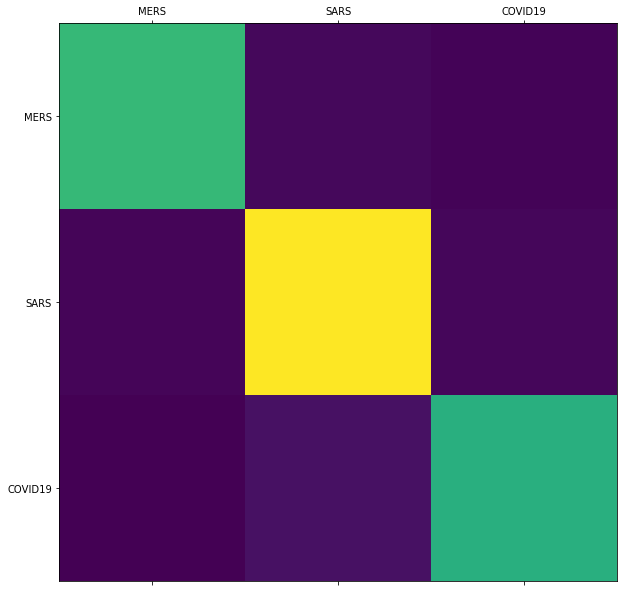

In [24]:
print("Model Training and Hyper-parameters Tuning for Logistic Regression\n")
print("TRAIN PERFORMANCE:")
df_lr,_ = virusTypeClassifier.train_model('LogisticRegression',True)
result = virusTypeClassifier.test_model(df_lr,df_X_test,df_y_test,True,model_name="LogisticRegression")

#### Naive Bayes

Laplace smoothing parameter alpha is used in hyperparameter tuning. Best performance model was found when **alpha=4.1**. Model got the training accuracy of **90.9%**, and got the test accuracy of **86.0%**.

Model Training and Hyper-parameters Tuning for Naive Bayes

TRAIN PERFORMANCE:
The best score of model MultinomialNB through 5-cross validation is 0.8580599144079886, with the best hyper-parameter {'alpha': 4.1}

Train accuracy of MultinomialNB model is 0.9087018544935807

Model MultinomialNB has test accuracy 0.8596783139212424

Test result report:

               precision    recall  f1-score   support

           0       0.95      0.77      0.85       524
           1       0.80      0.93      0.86       774
           2       0.88      0.85      0.86       505

    accuracy                           0.86      1803
   macro avg       0.88      0.85      0.86      1803
weighted avg       0.87      0.86      0.86      1803
 



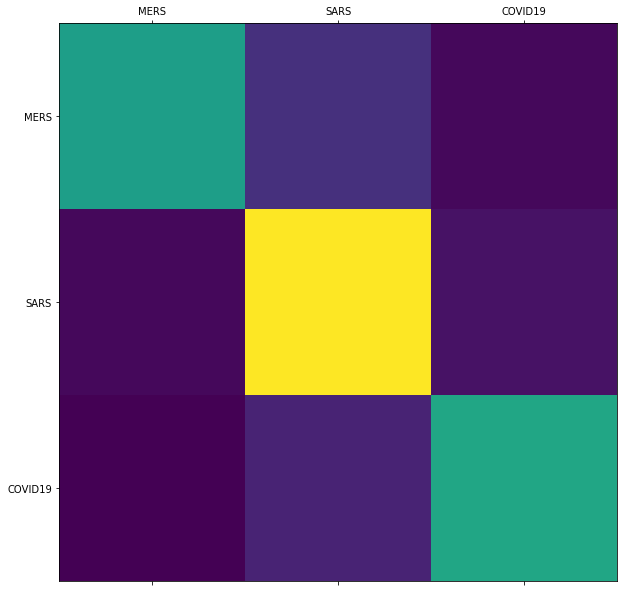

In [25]:
print("Model Training and Hyper-parameters Tuning for Naive Bayes\n")
print("TRAIN PERFORMANCE:")
df_nb,_ = virusTypeClassifier.train_model('MultinomialNB',True)
result = virusTypeClassifier.test_model(df_nb,df_X_test,df_y_test,True,model_name="MultinomialNB")

#### SVM (Linear SVC):

Regularization parameter C is used in hyperparameter tuning. Best performance model was found when **C=0.1**. Model got the training accuracy of **100.0%**, and got the test accuracy of **95.5%**.

Model Training and Hyper-parameters Tuning for Linear SVC

TRAIN PERFORMANCE:
The best score of model LinearSVC through 5-cross validation is 0.9562529719448407, with the best hyper-parameter {'C': 0.1}

Train accuracy of LinearSVC model is 1.0

Model LinearSVC has test accuracy 0.9550748752079867

Test result report:

               precision    recall  f1-score   support

           0       0.98      0.96      0.97       524
           1       0.94      0.96      0.95       774
           2       0.95      0.94      0.95       505

    accuracy                           0.96      1803
   macro avg       0.96      0.95      0.96      1803
weighted avg       0.96      0.96      0.96      1803
 



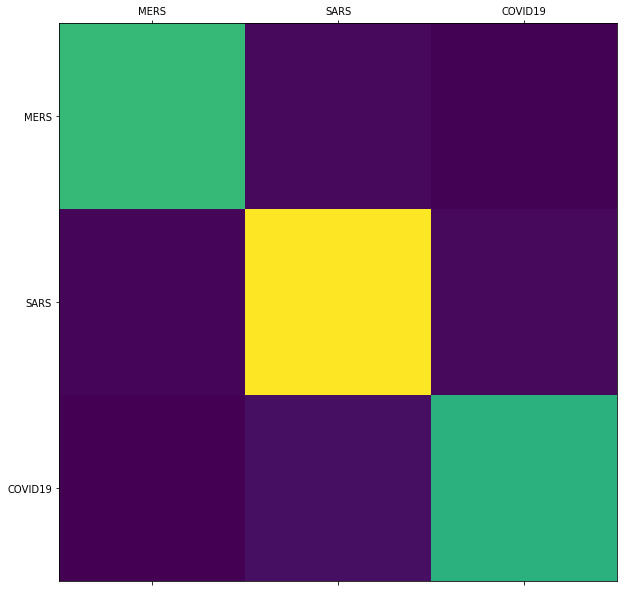

In [26]:
print("Model Training and Hyper-parameters Tuning for Linear SVC\n")
print("TRAIN PERFORMANCE:")
df_svc,_ = virusTypeClassifier.train_model('LinearSVC',True)
result = virusTypeClassifier.test_model(df_svc,df_X_test,df_y_test,True,model_name="LinearSVC")

#### Algorithm Comparision:
|  Model            |train_acc|test_acc|
|---                |---   |---   | 
|Logistic Regression|99.6%|95.7%|
|Linaer SVC         |100.0%|95.5%|
|Naive Bayes        |90.9%|86.0%|

**Logistic Regression** turned out to be the best in terms of testing accuracy 

### 3.2 Unsupervised machine learning using Hierarchical Clustering

Since we have successfully divided the dataset to 5 classes wrt different types of coronavirus topics using K-means clustering . We can perform unsupervised machine learning using hierarchical clustering to further investigate how different types of coronavirus differs in symptoms.


#### 3.2.1 Generate the Distance Matrix  with Selected Keywords

In [27]:
#We pick the top 10 frequently mentioned symptoms
symptoms = ['pneumonia','fever','diarrhea','cough','vomiting','weight loss',
            'edema','anxiety','dyspnea','depression']
virus_type = ['MERS', 'SARS', 'COVID19']

symptoms_and_virus_type = symptoms + virus_type

In [28]:
#Define the metric that will be used to define the "distance" metric used in the heirarchical clustering algorithm
symptom_dist = np.zeros((len(symptoms),len(symptoms)), dtype=float)
df_symptoms = pd.DataFrame(symptom_dist, columns=symptoms, index=symptoms)

In [29]:
#Helper function that will calculate the distance

def cumulative_dist(symptom1, symptom2, df):
    cum_sum = 0
    number_of_papers = 0
    if symptom1 == symptom2: return 0
    
    for abstract in df['cleaned_abstract']:
        if ((symptom1 in abstract) and (symptom2 in abstract)):
            number_of_papers += 1
            cum_sum -= 1
        elif (((symptom1 in abstract) and (symptom2 not in abstract)) or ((symptom1 not in abstract) and (symptom2 in abstract))):
            number_of_papers += 1
            cum_sum += 1
    
    return cum_sum/number_of_papers


#Populate Matrix of symptom distances by mining the text of the papers found in the database and using the distance rule as

#For a symptom A and B mentioned in a paper together the distanceA_B += 1 
# or distanceA_B -= 1 if they are not mentioned together

symptom_dist = np.zeros((len(symptoms),len(symptoms)),float)
#print(symptom_dist)
#print()
for i in range(len(symptoms)):
    for j in range(len(symptoms)):
         symptom_dist[i][j] = cumulative_dist(symptoms[i],symptoms[j], df_selected)   

In [30]:
i = 0
for symptom in symptoms:
    df_symptoms[symptom] = np.power(symptom_dist[i],9)
    i += 1
print('Our distance matrix looks like this:')   
df_symptoms

Our distance matrix looks like this:


,pneumonia,fever,diarrhea,cough,vomiting,weight loss,edema,anxiety,dyspnea,depression
pneumonia,0.000000,0.057243,0.558110,0.122501,0.792863,0.857401,0.791001,0.843043,0.517290,0.926664
fever,0.057243,0.000000,0.197950,0.000005,0.460248,1.000000,0.890581,0.806766,0.195335,0.891894
diarrhea,0.558110,0.197950,0.000000,0.058537,0.019597,0.869760,0.864880,0.897820,0.150460,0.870694
cough,0.122501,0.000005,0.058537,0.000000,0.259679,1.000000,0.926863,0.878536,0.036855,0.928603
vomiting,0.792863,0.460248,0.019597,0.259679,0.000000,1.000000,1.000000,1.000000,0.351815,1.000000
weight loss,0.857401,1.000000,0.869760,1.000000,1.000000,0.000000,0.692534,1.000000,1.000000,1.000000
edema,0.791001,0.890581,0.864880,0.926863,1.000000,0.692534,0.000000,0.654681,1.000000,0.472161
anxiety,0.843043,0.806766,0.897820,0.878536,1.000000,1.000000,0.654681,0.000000,0.850300,0.001050
dyspnea,0.517290,0.195335,0.150460,0.036855,0.351815,1.000000,1.000000,0.850300,0.000000,0.784069
depression,0.926664,0.891894,0.870694,0.928603,1.000000,1.000000,0.472161,0.001050,0.784069,0.000000


In [31]:
distance = np.power(symptom_dist,9)  #Magnify the distance prior to HCA
#distance
Y = sch.linkage(distance, method='centroid')

#### 3.2.2 Hierarchical Clustering for all three outbreaks (MERS, SARS, COVID19)

Text(0.5, 1.0, 'Dendrogram Displaying Symptom Clusters for all three outbreaks(MERS, SARS, COVID19)')

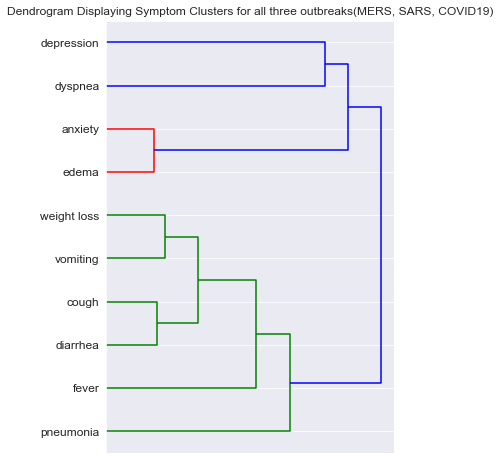

In [51]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_axes([0.1,0.1,0.4,0.6])

# Get dendrograms
Z1 = sch.dendrogram(Y, orientation='right')

ax1.set_xticks([])
ax1.set_yticklabels(symptoms)
ax1.set_title("Dendrogram Displaying Symptom Clusters for all three outbreaks(MERS, SARS, COVID19)")

> For top 10 related symptoms identified previously, 

#### 3.2.3 Hierarchical Clustering for COVID19

Text(0.5, 1.0, 'Dendrogram Displaying COVID-19 Symptom Clusters')

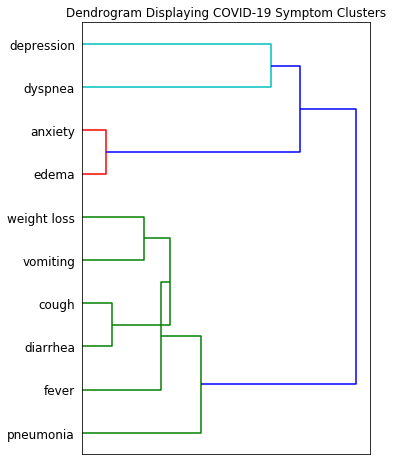

In [33]:
for i in range(len(symptoms)):
    for j in range(len(symptoms)):
         symptom_dist[i][j] = cumulative_dist(symptoms[i],symptoms[j], 
                                              df_selected[df_selected['virus_type']=='covid-19'])
    i = 0
for symptom in symptoms:
    df_symptoms[symptom] = np.power(symptom_dist[i],9)
    i += 1

distance = np.power(symptom_dist,9)  #Magnify the distance prior to HCA
#distance

Y = sch.linkage(distance, method='centroid')

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_axes([0.1,0.1,0.4,0.6])

# Get dendrograms
Z1 = sch.dendrogram(Y, orientation='right')

ax1.set_xticks([])
ax1.set_yticklabels(symptoms)
ax1.set_title("Dendrogram Displaying COVID-19 Symptom Clusters")

#### 3.2.4 Hierarchical Clustering for MERS-CoV

Text(0.5, 1.0, 'Dendrogram Displaying MERS-CoV Symptom Clusters')

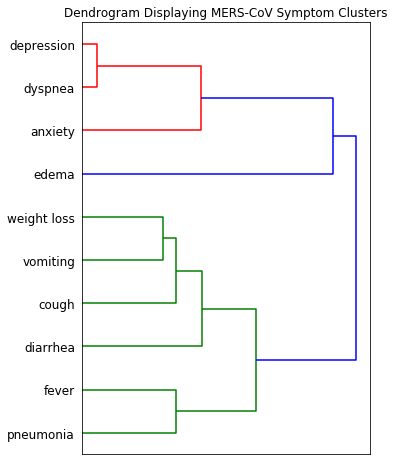

In [34]:
for i in range(len(symptoms)):
    for j in range(len(symptoms)):
         symptom_dist[i][j] = cumulative_dist(symptoms[i],symptoms[j], 
                                              df_selected[df_selected['virus_type']=='mers-cov'])
    i = 0
for symptom in symptoms:
    df_symptoms[symptom] = np.power(symptom_dist[i],9)
    i += 1

distance = np.power(symptom_dist,9)  #Magnify the distance prior to HCA
#distance

Y = sch.linkage(distance, method='centroid')

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_axes([0.1,0.1,0.4,0.6])

# Get dendrograms
Z1 = sch.dendrogram(Y, orientation='right')

ax1.set_xticks([])
ax1.set_yticklabels(symptoms)
ax1.set_title("Dendrogram Displaying MERS-CoV Symptom Clusters")

#### 3.2.5 Hierarchical Clustering for SARS-CoV

Text(0.5, 1.0, 'Dendrogram Displaying SARS-CoV Symptom Clusters')

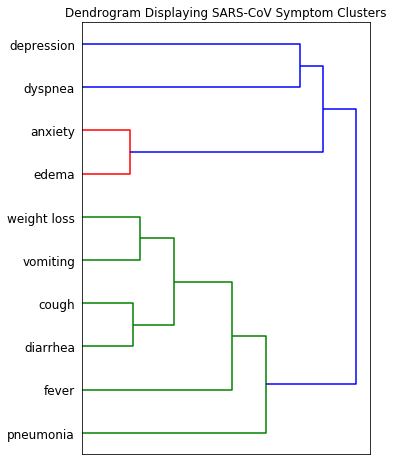

In [35]:
for i in range(len(symptoms)):
    for j in range(len(symptoms)):
         symptom_dist[i][j] = cumulative_dist(symptoms[i],symptoms[j], 
                                              df_selected[df_selected['virus_type']=='sars-cov'])
    i = 0
for symptom in symptoms:
    df_symptoms[symptom] = np.power(symptom_dist[i],9)
    i += 1

distance = np.power(symptom_dist,9)  #Magnify the distance prior to HCA
#distance

Y = sch.linkage(distance, method='centroid')

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_axes([0.1,0.1,0.4,0.6])

# Get dendrograms
Z1 = sch.dendrogram(Y, orientation='right')

ax1.set_xticks([])
ax1.set_yticklabels(symptoms)
ax1.set_title("Dendrogram Displaying SARS-CoV Symptom Clusters")

#### From Hierarchical Clustering Dendrogram for different coronavirus, we can conclude that:

> Symptoms are broken into 2 categories. First category includes edema, anxiety, dyspnea, depression, which is more closely related to the mental state of the patient. Second category includes pneumonia, fever, diarrhea, cough, vomiting, weight loss.

> For second category, the clusters are grouped according to the order of severity. Mild symptoms includes vomiting which often results in weight loss and cough which often comes with diarrhea. More serious illness can be developed such as fever or even pneumonia.

## 4 Deriving insights about policy and guidance to tackle the outbreak based on model findings – [30 Marks]:

Using the findings from your NLP model and text mining 35,000 unique biomedical research papers on the coronavirus you are now tasked with discussing and proposing how scientists, doctors, nurses, healthcare professionals, industry and governments can best use the insights from your data science model to assist in the fight against the COVID-19 pandemic. Use the insights derived about the disease from your model and your data analysis to justify proposed policies or action items.

### 4.1 Symptoms of COVID-19

According to our analysis, the most common symptoms of COVID-19 are pneumonia, fever, diarrhea, cough and tiredness. These symptoms are usually mild and begin gradually. Some people become infected but don’t develop any symptoms and don't feel unwell. But those with underlying medical problems like high blood pressure and bad habits like smoking are more likely to develop serious illness. 

### 4.2 Self Protection and Spread Prevention

Some simple precautions can be taken right now reduce chances of being infected or spreading COVID-19:

1. Regularly and thoroughly clean your hands with an alcohol-based hand rub or wash them with soap and water.

2. Social distancing, maintain at least 2 meters distance between yourself and others.

3. Avoid touching eyes, nose and mouth without washing hands.

4. Avoid going to places with high density of people.

5. Wear face mask if have to perform outdoor activities.

### 4.3 After Infection

Self-care
If you have mild symptoms, stay at home until you’ve recovered. You can relieve your symptoms if you:
1. rest and sleep to alleviate tiredness
2. drink plenty of liquids to alleviate cough and mild fever
3. use a room humidifier or take a hot shower to help ease a sore throat

Medical treatments
If you develop a severe fever, cough, and have difficulty breathing, need to seek medical care immediately.